In [1]:
%load_ext autoreload
%autoreload 2

# Segmentation

## Règles

_Avant de s’interroger sur les responsabilités d’un algorithme, il faut être en mesure d’identifier quel algorithme est la source de telle décision. Ainsi, en parallèle des conférences, la société civile est invitée dans le cadre d’un Hackathon, à contribuer à la résolution de ce problème ouvert via des techniques d’intelligence artificielle._
_Le Hackathon propose un cas simplifié, mais réaliste, de plateforme de livraison de plats cuisinés. La plateforme affiche à l’utilisateur un tarif unique pour chaque livraison, depuis un restaurant jusqu’au lieu de collecte. Plusieurs options sont possibles pour l'établissement de ce tarif : le restaurant décide quelle option de livraison et/ou tarification de livraison s’applique à lui parmi différents algorithmes proposés par la plateforme ou la tarification est complètement à la main du restaurant._

_Pour comprendre les responsabilités à l’œuvre, les participants inscrits auront pour mission de détecter à partir du jeu de données fourni quel algorithme fixe quelle tarification. Afin d’aider les participants, le jeu de données contient des informations récupérées sur la plateforme fictive (e.g. le lieu de livraison) comme des données contextuelles (e.g. des informations sur la météo locale). Toute donnée supplémentaire apportée par les candidats est bienvenue._

## Méthodologie

## Objectif visé
Déterminer, pour chaque commande, le mode de tarification utilisé (variable caché) étant donné le tarif affiché à l'utilisateur (qui est notre observable).

### Données utilisées (et sources)
Météo (jdd fourni)
Géolocalisation des points de livraison (jdd fourni)
Géolocalisation des commerces (jdd fourni)
Jour et heure (jdd fourni)

### Spécifications techniques du code
python3.10
sklearn==1.1.0

## Feature engineering

In [2]:
import pandas as pd
tarifs = pd.read_csv("tarifs.csv")

In [3]:
tarifs.head()

,observation_uuid,start_lat,start_lon,start_code_postal,end_lat,end_lon,end_code_postal,rain,heat,day_of_week,hour,minute,fee
0,0d742256-0b36-f3cd-0acf-eba4441030ae,48.8406,2.3220,75014,48.8262,2.3192,75014,2,5,Saturday,13,44,1.69
1,743c7e9d-2fde-b035-2452-bc39dbf2eed1,48.8472,2.3527,75005,48.8337,2.3880,75012,9,3,Tuesday,14,14,1.59
2,43893bc5-449c-56ef-3857-ebe679ffa869,48.9015,2.3704,75019,48.8814,2.3484,75009,1,9,Sunday,14,39,2.19
3,284884a2-55e5-c1d9-b036-4ad9ee5be9b9,48.8504,2.2902,75015,48.8716,2.2811,75016,6,2,Thursday,12,46,1.79
4,a0ce5b5f-ca56-3921-f942-2f1efed97f9e,48.8583,2.3894,75011,48.8623,2.3426,75001,2,6,Friday,13,38,2.09


#### Adding restaurant id.
#### Also addd addresses (?) (seem to be useless. Maybe the addressed are anonymized ?)

In [4]:
tarifs["id"] = tarifs.apply(lambda row: str(row["start_lat"]) + str(row["start_lon"]), axis=1)

In [5]:
"""
tarifs["lat"] = tarifs["start_lat"]
tarifs["lon"] = tarifs["start_lon"]
tarifs.to_csv("tarifs_geo.csv")
!curl -X POST -F data=@tarifs_geo.csv https://api-adresse.data.gouv.fr/reverse/csv/ > tarifs_adresses.csv
"""


'\ntarifs["lat"] = tarifs["start_lat"]\ntarifs["lon"] = tarifs["start_lon"]\ntarifs.to_csv("tarifs_geo.csv")\n!curl -X POST -F data=@tarifs_geo.csv https://api-adresse.data.gouv.fr/reverse/csv/ > tarifs_adresses.csv\n'

### Distance

In [6]:
import numpy as np

In [7]:
# Création de la colonne "distance au point de livraison"
tarifs["d"] = np.sqrt((tarifs["end_lon"]-tarifs["start_lon"])**2 + (tarifs["end_lat"]-tarifs["start_lat"])**2)

## Arrondissement

In [8]:
# it works because the last 2 digits of code INSEE equals the arrondissement number for Paris
tarifs["arrondissement"] = tarifs.apply(lambda row: str(row["end_code_postal"])[-2:], axis=1)

## Jour

In [9]:
day_dict = {"Monday": 1, "Tuesday": 2, "Wednesday": 3, "Thursday": 4, "Friday": 5, "Saturday": 6, "Sunday": 7}
tarifs["day_code"] = tarifs.apply(lambda row: day_dict[row["day_of_week"]], axis=1)
df = tarifs[["id", "rain", "heat", "day_code", "hour", "fee", "d", "arrondissement", "observation_uuid", "minute"]]
df.head(10)

,id,rain,heat,day_code,hour,fee,d,arrondissement,observation_uuid,minute
0,48.84062.322,2,5,6,13,1.69,0.014670,14,0d742256-0b36-f3cd-0acf-eba4441030ae,44
1,48.84722.3527,9,3,2,14,1.59,0.037793,12,743c7e9d-2fde-b035-2452-bc39dbf2eed1,14
2,48.90152.3704,1,9,7,14,2.19,0.029799,09,43893bc5-449c-56ef-3857-ebe679ffa869,39
3,48.85042.2902,6,2,4,12,1.79,0.023071,16,284884a2-55e5-c1d9-b036-4ad9ee5be9b9,46
4,48.85832.3894,2,6,5,13,2.09,0.046971,01,a0ce5b5f-ca56-3921-f942-2f1efed97f9e,38
5,48.84842.2891,2,6,5,12,1.89,0.020339,07,de386aeb-ea96-abe6-299c-f16b5a7583c0,5
6,48.84242.3476,3,2,6,12,2.09,0.029937,14,234131e2-5dce-8477-c9e1-893ec3fb3743,37
7,48.83632.3069,3,1,4,14,2.59,0.044840,16,0703c5f1-5b4f-5458-6523-923afe963e96,18
8,48.88552.3214,1,4,5,13,3.29,0.040730,15,aedab7b5-e2aa-55a7-4951-03edfd05a5f5,18
9,48.84572.3192,2,7,4,12,2.49,0.041856,17,15dde31a-b9e4-4e0e-3fab-916954101fe9,38


In [10]:
# prise en compte de la météo

## Méthodologie de validation

In [11]:
from sklearn.model_selection import train_test_split
## à faire plus tard avant de soumettre

## Analyse de l'algorithme

In [12]:
# Nos idées, à mettre plus tard dans le README.md (à la fin du hackathon)

### Modèle constant (mod 1) et modèle rain - deux valeurs selon qu'on est  rain>=6 ou non  (outdated - mod 2)

In [13]:
df["rain_thresh"] = False
df.loc[df["rain"]>=6,"rain_thresh"]=1 # values 6, 7, 8, 9
restaurant_model = df[["fee", "id"]].groupby("id").nunique().reset_index()
restaurant_model["model"] = 0
restaurant_model.loc[restaurant_model["fee"]==1, "model"] = 1
restaurant_model

/tmp/ipykernel_34671/2720529058.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["rain_thresh"] = False
/tmp/ipykernel_34671/2720529058.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df["rain"]>=6,"rain_thresh"]=1 # values 6, 7, 8, 9


,id,fee,model
0,48.81712.3343,4,0
1,48.81892.3484,5,0
2,48.81982.3329,7,0
3,48.81982.3459,6,0
4,48.81982.3503,7,0
...,...,...,...
595,48.89932.3477,7,0
596,48.89952.3286,6,0
597,48.89962.3456,5,0
598,48.90142.386,7,0


In [14]:
df = pd.merge(df, restaurant_model[["id", "model"]], left_on="id", right_on="id")

### Pearson correlation (fee, distance)

In [15]:
from scipy.stats import pearsonr

grouped = df[["id", "d", "fee"]].groupby("id").agg(list)
grouped["corr_d"] = grouped.apply(
    lambda row: pearsonr(x=row["fee"], y=row["d"])[0],axis=1
)

df = pd.merge(df, grouped[["corr_d"]].reset_index(), left_on="id", right_on="id")


/home/pierre/.local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [17]:
CORR_D_THRESH = 0.3
df["corr_d_thresh"] = 0
df.loc[df["corr_d"] > CORR_D_THRESH, "corr_d_thresh"] = 1

In [18]:
# if it was not constant, characterize low correlation (fee, distance) as model 2
df.loc[(df["corr_d_thresh"]==0) & (df["model"] != 1), "model"] = 2
df

,id,rain,heat,day_code,hour,fee,d,arrondissement,observation_uuid,minute,rain_thresh,model,corr_d,corr_d_thresh
0,48.84062.322,2,5,6,13,1.69,0.014670,14,0d742256-0b36-f3cd-0acf-eba4441030ae,44,False,0,0.938686,1
1,48.84062.322,2,5,1,12,2.19,0.026921,01,38dfe76b-ae35-8290-6d80-ab08c963d148,53,False,0,0.938686,1
2,48.84062.322,5,4,1,14,2.39,0.034873,16,104dff66-23f1-b67e-01d3-4690a795ac54,11,False,0,0.938686,1
3,48.84062.322,2,2,6,13,1.59,0.016300,07,8ec9ea98-6581-f934-9bcf-b1c4f87e3560,53,False,0,0.938686,1
4,48.84062.322,1,9,3,14,2.49,0.042489,16,4a30f7cd-00fd-ec23-598c-a3b429b10823,37,False,0,0.938686,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4795,48.83332.3991,0,1,6,14,1.79,0.030320,12,9f3176c0-468b-db70-8b6e-6609f5b9cc00,8,False,0,0.599853,1
4796,48.83332.3991,0,6,1,12,0.99,0.027606,13,c175de4b-7901-0563-f200-e63ad5700b5a,35,False,0,0.599853,1
4797,48.83332.3991,9,4,6,13,1.89,0.040209,13,126bbdd7-f8d1-cd15-e017-68c509c0fbd4,8,1,0,0.599853,1
4798,48.83332.3991,2,4,4,13,0.99,0.025097,13,37448afb-3023-73be-3a6d-7a7e16706465,22,False,0,0.599853,1


### Pearson correlation (fee, hour)

In [19]:
from scipy.stats import pearsonr
df["t"] = df["hour"]*60+df["minute"]
grouped = df[["id", "t", "fee"]].groupby("id").agg(list)
grouped["corr_t"] = grouped.apply(
    lambda row: pearsonr(x=row["fee"], y=row["t"])[0],axis=1
)

df = pd.merge(df, grouped[["corr_t"]].reset_index(), left_on="id", right_on="id")


/home/pierre/.local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [20]:
df


,id,rain,heat,day_code,hour,fee,d,arrondissement,observation_uuid,minute,rain_thresh,model,corr_d,corr_d_thresh,t,corr_t
0,48.84062.322,2,5,6,13,1.69,0.014670,14,0d742256-0b36-f3cd-0acf-eba4441030ae,44,False,0,0.938686,1,824,0.330079
1,48.84062.322,2,5,1,12,2.19,0.026921,01,38dfe76b-ae35-8290-6d80-ab08c963d148,53,False,0,0.938686,1,773,0.330079
2,48.84062.322,5,4,1,14,2.39,0.034873,16,104dff66-23f1-b67e-01d3-4690a795ac54,11,False,0,0.938686,1,851,0.330079
3,48.84062.322,2,2,6,13,1.59,0.016300,07,8ec9ea98-6581-f934-9bcf-b1c4f87e3560,53,False,0,0.938686,1,833,0.330079
4,48.84062.322,1,9,3,14,2.49,0.042489,16,4a30f7cd-00fd-ec23-598c-a3b429b10823,37,False,0,0.938686,1,877,0.330079
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4795,48.83332.3991,0,1,6,14,1.79,0.030320,12,9f3176c0-468b-db70-8b6e-6609f5b9cc00,8,False,0,0.599853,1,848,0.102633
4796,48.83332.3991,0,6,1,12,0.99,0.027606,13,c175de4b-7901-0563-f200-e63ad5700b5a,35,False,0,0.599853,1,755,0.102633
4797,48.83332.3991,9,4,6,13,1.89,0.040209,13,126bbdd7-f8d1-cd15-e017-68c509c0fbd4,8,1,0,0.599853,1,788,0.102633
4798,48.83332.3991,2,4,4,13,0.99,0.025097,13,37448afb-3023-73be-3a6d-7a7e16706465,22,False,0,0.599853,1,802,0.102633


<AxesSubplot:xlabel='corr_t', ylabel='Count'>

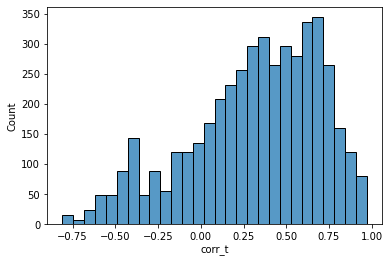

In [26]:
import seaborn as sns

#sns.histplot(df["corr_t"])

In [83]:
CORR_T_UPPER_THRESH = 0.3
CORR_T_LOWER_THRESH = -0.3
df["corr_t_thresh"] = 0
df.loc[(df["corr_t"] > CORR_T_UPPER_THRESH) | (df["corr_t"] < CORR_T_LOWER_THRESH), "corr_t_thresh"] = 1


In [84]:
df.to_csv("export_1432.csv")

## Visualisation de données

In [ ]:
"""
import plotly.express as px
counts, bins = np.histogram(df_annotated.fee, bins=301)
bins = 0.5 * (bins[:-1] + bins[1:])

fig = px.bar(x=bins, y=counts, labels={'x':'fee', 'y':'count'})
fig.show()
"""

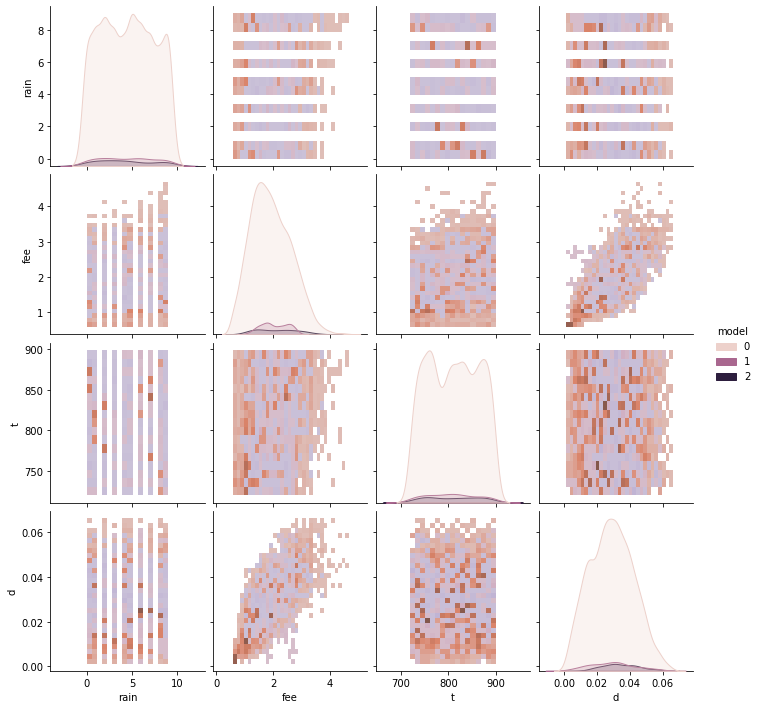

In [88]:
import seaborn as sns
import plotly # https://plotly.com/python/

sns.pairplot(df[["rain", "model", "fee", "t", "d"]], hue="model", kind="hist", diag_kind="kde")#, palette="id") #, hue="col1", palette="col2")
# visualisation 2D à creuser : (distance OU temps OU nb course) x commmission 
# notion éventuelle de bonus pour certaines courses à certains moments ou certains endroits 
# bonus : (regarder la série temporelle de la tarification moyenne), ou la distribution géographique

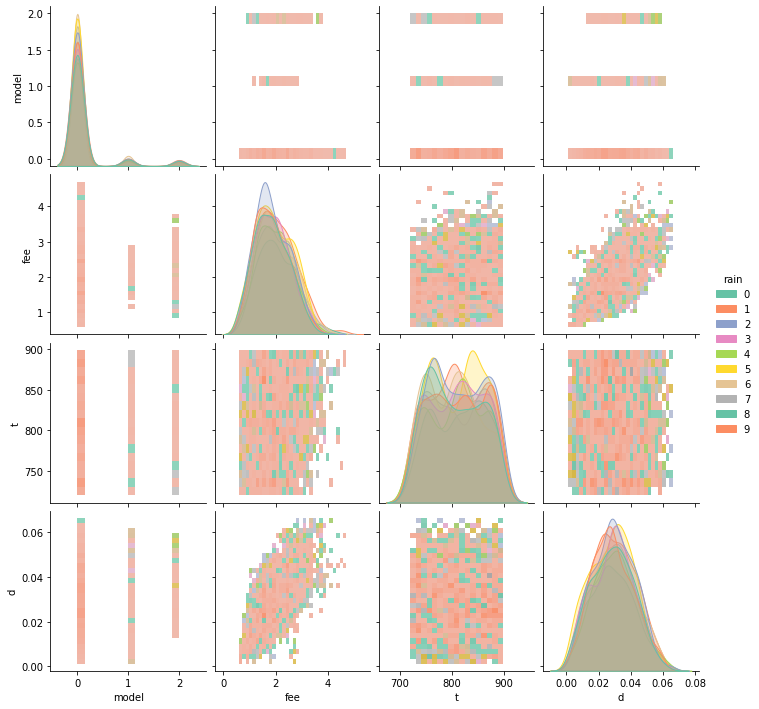

In [87]:
import seaborn as sns
import plotly # https://plotly.com/python/

sns.pairplot(df[["rain", "model", "fee", "t", "d"]], hue="rain", kind="hist", diag_kind="kde", palette=sns.color_palette("Set2", 10))

### Hypothese 0: constant prices

In [76]:
X = df[["d", "fee", "rain"]][df.model != 1].values
X.shape

(4560, 3)

### Modélisation avec des ellipses pour gérer le bruit sur la distance (pour plus tard ?)

In [77]:
from sklearn.mixture import GaussianMixture
from sklearn.mixture import BayesianGaussianMixture
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

#model = GaussianMixture(n_components=3, covariance_type="full")
model = BayesianGaussianMixture(n_components=3)

pip = make_pipeline(StandardScaler(), model)

pip.fit(X)
# https://runebook.dev/fr/docs/scikit_learn/modules/mixture#bgmm (traduction de la doc scikit-learn)
# https://scikit-learn.org/dev/modules/mixture.html#mixture
# make_pipeline(StandardScaler(), model)

/home/pierre/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:286: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('bayesiangaussianmixture',
                 BayesianGaussianMixture(n_components=3))])

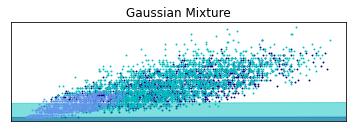

In [78]:

import itertools

import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn import mixture

color_iter = itertools.cycle(["navy", "c", "cornflowerblue", "gold", "darkorange"])

def plot_results(X, Y_, means, covariances, index, title):
    splot = plt.subplot(2, 1, 1 + index)
    for i, (mean, covar, color) in enumerate(zip(means, covariances, color_iter)):
        v, w = linalg.eigh(covar)
        v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y_ == i):
            continue
        plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], 0.8, color=color)

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180.0 * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180.0 + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        splot.add_artist(ell)

    plt.xticks(())
    plt.yticks(())
    plt.title(title)
    
plot_results(X, pip.predict(X), model.means_, model.covariances_, 0, "Gaussian Mixture")